### There are several methods of Documents Embedding Techniques in NLP
### Such as 
#### 1.	Bag of Word 
Bag-Of-Words (BOW) is a popular basic approach to generate document representation. A text is represented as a bag containing plenty of words. The grammar and word order are neglected while the frequency is kept the same. A feature generated by bag-of-words is a vector where n is the number of words in the input documents vocabulary. If our dataset contains a big number of unique words some of that are not used very frequently, which is usually the case? So, among those, we chose N most frequent words and create a feature vector of dimension Nx1. These feature vectors are then used for any machine learning task.

#### 2.	Word2vec algorithms
Word2vec representation is created using 2 algorithms: Continuous Bag-of-Words model (CBOW) and the Skip-Gram model. Continuous bag of words creates a sliding window around current word, to predict it from “context” - the surrounding words. Each word is represented as a feature vector. After training, these vectors become the word vectors. The second algorithm is actually the opposite of CBOW: instead of predicting one word each time, we use 1 word to predict all surrounding words (“context”). Skip gram is much slower than CBOW, but considered more accurate with infrequent words.

#### 3.	Paragraph vectors (doc2vec)
Doc2vec is a very popular technique. It’s easy to use, gives good results, and heavily based on word2vec. Now words maintain logical (grammatical) structure but documents don’t have any logical structures. To solve this problem another vector (Paragraph ID) needs to add with word2vec model. This is the only difference between word2vec and doc2vec. There are two flavor of doc2vec are available: 1) PV-DM 2) PV-DBOW

#### 4.	Doc2VecC
In order to tackle the problems in Doc2Vec, presented a new approach to include global context by capturing the semantic meanings of the document during learning called Doc2Vec Corruption (Doc2VecC). The output of Doc2VecC is a vector representation of words that shares global and local semantics of the dataset. To generate a document representation, we compute the average of the word vectors. This results in a better representation than using embedding from word2vec.


#### 5.	Term Frequency-Inverse Document Frequency
TF-IDF provides a statistical measure used to evaluate the importance of the words with respect to the document in a collection. By definition, TF-IDF embedding is composed by two terms: the first computes the normalized Term Frequency (TF) the occurrence a word appears in a document, divided by the total number of words in that document. The second term is the Inverse Document Frequency (IDF) which computes the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

#### 6.	Averaging word embedding
There is a very intuitive way to construct document embeddings from meaningful word embeddings: Given a document, perform some vector arithmetic on all the vectors corresponding to the words of the document to summarize them into a single vector in the same embedding space. Two such common summarization operators are average and sum. Building upon this, you can perhaps already imagine that extending the encoder-decoder architecture of word2vec and its relatives to learn how to combine word vectors into document embeddings can be interesting.

#### 7.	Word Mover’s Embedding (WME)
A very recent method, coming out of IBM research, is Word Mover’s Embedding (WME). This measures the dissimilarity between two text documents as the minimum amount of distance that the embedded words of one document need to “travel” in the embedding space to reach the embedded words of another document. Its two building blocks, word2vec and WMD, can be replaced by other techniques such as Glove (for word embeddings) or S-WMD.

#### 8.	Sentence-BERT (SBERT)
Models generate contextual embeddings of input tokens. Each infused with information of its neighbourhood, but is not aimed at generating a rich embedding space for input sequences. BERT even has a special token whose output embedding is used for classification tasks, but still turns out to be a poor embedding of the input sequence for other tasks. Sentence-BERT aims to adapt the BERT architecture by using Siamese and triplet network structures to derive semantically meaningful sentence embedding that can be compared using cosine-similarity.


### Using the Document Embedding Techniques in NLP concepts perform text classification for the data given, 
### such that any new text given it could be classified into any of the given classes in the Dataset.

## Dataset Description

#### BBC-full-text-document-classification

data for text classification_to make a model:
https://drive.google.com/file/d/1Vyn8_R28V25mp6fYK75gLGGvArIty_mS/view?usp=sharing

## Data Preprocessing  

In [23]:
#importing required Libraries 
import glob
import multiprocessing
import time

#Importing libraries for Doc2Vec implimentation 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#libraries which are used in deep learning 
from keras.backend import floatx
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
# Set random seed (for reproducibility)
random.seed(1000)

#Load the given data 
bbc_cls = 'C:/Users/Hp/Desktop/MyWaysData/task2/bbc'
bbc_news_categories = {
    'business': 1,
    'entertainment': 2,
    'politics': 3,
    'sport': 4,
    'tech': 5
}

# News data (X) and category (Y)
bbc_news_X = []
bbc_news_Y = []

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
regexp_tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

### Tokenize, remove stop-words and lemmatize

In [4]:
def tokenize(document, rebuild_document=True):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [wordnet_lemmatizer.lemmatize(t.lower()) 
                  for t in regexp_tokenizer.tokenize(sentence) if t.lower() not in stop_words]
        words += tokens

    if rebuild_document:
        return ' '.join(words).strip()
    else:
        return words

### Import news and create train and test datasets

In [5]:
for category_label, category_idx in bbc_news_categories.iteritems():
    print('Processing category: %s (%d)' % (category_label, category_idx))
    
    for news_file_name in glob.glob(bbc_cls + category_label + '\\*.txt'):
        with open(news_file_name, 'r') as news_file:
            news_data = news_file.read()
        
        bbc_news_X.append(tokenize(news_data.decode('ISO-8859-1')))
        bbc_news_Y.append(category_idx)
        
print('Corpus size: %d' % len(bbc_news_X))

# Split the whole corpus in train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(bbc_news_X, bbc_news_Y, test_size=0.25)

Processing category: politics (3)
Processing category: sport (4)
Processing category: tech (5)
Processing category: business (1)
Processing category: entertainment (2)
Corpus size: 2225


### Support functions and data

In [6]:
precisions_micro = []
precisions_macro = []
recalls_micro = []
recalls_macro = []
f1s_micro = []
f1s_macro = []

def plot_confusion_matrix(Y_test, Y_pred):
    cmatrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
    cm_fig, cm_ax = subplots(figsize=(8.0, 8.0))
    cm_ax.matshow(cmatrix, cmap=cm.GnBu)

    cm_ax.set_xticklabels([''] + bbc_news_categories.keys())
    cm_ax.set_yticklabels([''] + bbc_news_categories.keys())

    for i in range(len(bbc_news_categories.keys())):
        for j in range(len(bbc_news_categories.keys())):
            cm_ax.text(x=j, y=i, s=cmatrix[i, j], va='center', ha='center')

    title('Confusion matrix')
    xlabel('Predicted categories')
    ylabel('Actual categories')

### All the pre-processing of the data is done with certaine methodes. after all the analysis now i am further develope the model with machine learning algorithms to get desired outputs.

### Models which i have choosen for this perticular project is
#### 1) Naive Bayes(TF)
#### 2) Naive Bayes(TF-IDF)
#### 3) SVM DOC2VEC
#### 4) MLP DOC2VEC

##  Naive Bayes approach

### Multinomial with Count Vectorizer

In [37]:
count_vectorizer = CountVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_cv_nb_pipeline = Pipeline([('vectorizer', count_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_cv_nb_param_grid = [
    { 
        'vectorizer__min_df': [ 1, 2, 3, 4, 5 ],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3) ],
        'multinomial_nb__alpha': [ 0.0, 0.25, 0.5, 0.75, 1.0 ]
    }
]

# Perform grid search
mn_cv_nb_gs = GridSearchCV(estimator=mn_cv_nb_pipeline, param_grid=mn_cv_nb_param_grid, 
                           scoring='accuracy', cv=25, n_jobs=multiprocessing.cpu_count())

mn_cv_nb_gs.fit(X_train, Y_train)

# Create an instance of the best estimator
mn_cv_nb_best = mn_cv_nb_gs.best_estimator_
mn_cv_nb_best.fit(X_train, Y_train)

print('Best model: %s' % str(mn_cv_nb_gs.best_params_))
print('Best score: %f' % mn_cv_nb_gs.best_score_)
print('Best test accuracy: %f' % mn_cv_nb_best.score(X_test, Y_test))

Best model: {'vectorizer__min_df': 2, 'multinomial_nb__alpha': 0.25, 'vectorizer__ngram_range': (1, 2)}
Best score: 0.979017
Best test accuracy: 0.987433


### Model evaluation

Precision score: 0.987433 (micro) / 0.986406 (macro)
Recall score: 0.987433 (micro) / 0.987845 (macro)
F1 score: 0.987433 (micro) / 0.986997 (macro)


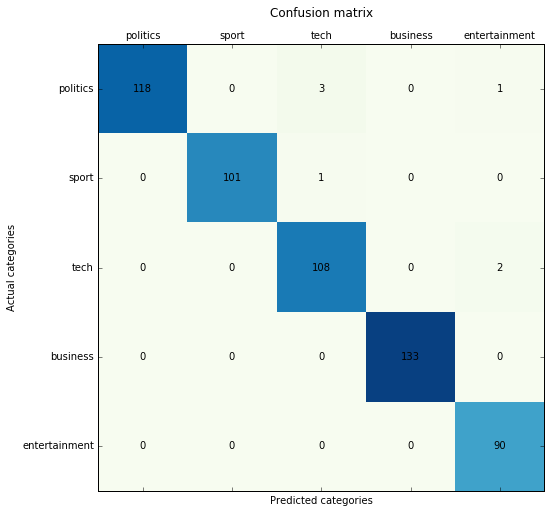

In [51]:
mn_cv_nb_Y_pred = mn_cv_nb_best.predict(X_test)

# Compute precision, recall and F1 scores with micro and macro averaging
mn_cv_nb_precision_micro = precision_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='micro')
mn_cv_nb_precision_macro = precision_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='macro')
mn_cv_nb_recall_micro = recall_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='micro')
mn_cv_nb_recall_macro = recall_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='macro')
mn_cv_nb_f1_micro = f1_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='micro')
mn_cv_nb_f1_macro = f1_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='macro')

precisions_micro.append(mn_cv_nb_precision_micro)
precisions_macro.append(mn_cv_nb_precision_macro)
recalls_micro.append(mn_cv_nb_recall_micro)
recalls_macro.append(mn_cv_nb_recall_macro)
f1s_micro.append(mn_cv_nb_f1_micro)
f1s_macro.append(mn_cv_nb_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (mn_cv_nb_precision_micro, mn_cv_nb_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (mn_cv_nb_recall_micro, mn_cv_nb_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (mn_cv_nb_f1_micro, mn_cv_nb_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(Y_test, mn_cv_nb_Y_pred)

### Multinomial with Tf-Idf Vectorizer

In [52]:
tfidf_vectorizer = TfidfVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_tfidfv_nb_pipeline = Pipeline([('vectorizer', tfidf_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_tfidfv_nb_param_grid = [
    { 
        'vectorizer__min_df': [ 1, 2, 3, 4, 5 ],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3) ],
        'vectorizer__norm': [ None, 'l1', 'l2' ],
        'vectorizer__smooth_idf': [True, False],
        'multinomial_nb__alpha': [ 0.0, 0.25, 0.5, 0.75, 1.0 ]
    }
]

# Perform grid search
mn_tfidfv_nb_gs = GridSearchCV(estimator=mn_tfidfv_nb_pipeline, param_grid=mn_tfidfv_nb_param_grid, 
                           scoring='accuracy', cv=25, n_jobs=multiprocessing.cpu_count())

mn_tfidfv_nb_gs.fit(X_train, Y_train)

# Create an instance of the best estimator
mn_tfidfv_nb_best = mn_tfidfv_nb_gs.best_estimator_
mn_tfidfv_nb_best.fit(X_train, Y_train)

print('Best model: %s' % str(mn_tfidfv_nb_gs.best_params_))
print('Best score: %f' % mn_tfidfv_nb_gs.best_score_)
print('Best test accuracy: %f' % mn_tfidfv_nb_best.score(X_test, Y_test))

Best model: {'vectorizer__min_df': 1, 'multinomial_nb__alpha': 0.5, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': None, 'vectorizer__smooth_idf': True}
Best score: 0.981415
Best test accuracy: 0.980251


### Model evaluation

Precision score: 0.980251 (micro) / 0.978598 (macro)
Recall score: 0.980251 (micro) / 0.980466 (macro)
F1 score: 0.980251 (micro) / 0.979228 (macro)


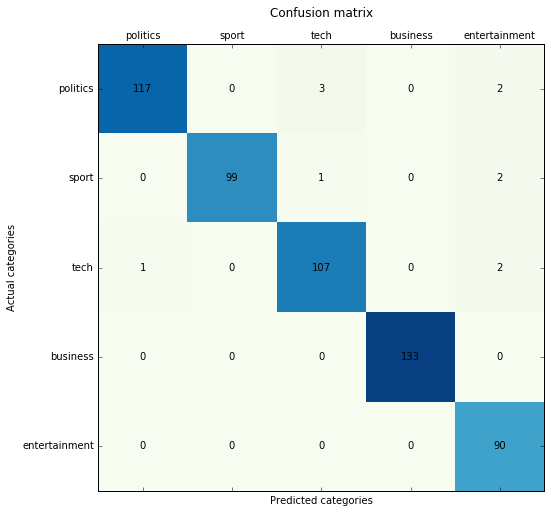

In [53]:
mn_tfidfv_nb_Y_pred = mn_tfidfv_nb_best.predict(X_test)

# Compute precision, recall and F1 scores with micro and macro averaging
mn_tfidfv_nb_precision_micro = precision_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='micro')
mn_tfidfv_nb_precision_macro = precision_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='macro')
mn_tfidfv_nb_recall_micro = recall_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='micro')
mn_tfidfv_nb_recall_macro = recall_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='macro')
mn_tfidfv_nb_f1_micro = f1_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='micro')
mn_tfidfv_nb_f1_macro = f1_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='macro')

precisions_micro.append(mn_tfidfv_nb_precision_micro)
precisions_macro.append(mn_tfidfv_nb_precision_macro)
recalls_micro.append(mn_tfidfv_nb_recall_micro)
recalls_macro.append(mn_tfidfv_nb_recall_macro)
f1s_micro.append(mn_tfidfv_nb_f1_micro)
f1s_macro.append(mn_tfidfv_nb_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (mn_tfidfv_nb_precision_micro, mn_tfidfv_nb_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (mn_tfidfv_nb_recall_micro, mn_tfidfv_nb_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (mn_tfidfv_nb_f1_micro, mn_tfidfv_nb_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(Y_test, mn_tfidfv_nb_Y_pred)

## Doc2Vec (Gensim-based) approach


In [11]:
# Create tagged documents
bbc_news_tagged_documents = []

for i, document in enumerate(bbc_news_X):
    bbc_news_tagged_documents.append(TaggedDocument(document.split(' '), [i]))
    
# Train Doc2Vec
doc2vec_vector_size = 50

doc2vec_model = Doc2Vec(documents=bbc_news_tagged_documents, size=doc2vec_vector_size, window=3, 
                        min_count=2, iter=30, workers=multiprocessing.cpu_count())
doc2vec_model.init_sims(replace=False)

# Vectorize documents and split the whole corpus in train and test sets
bbc_news_vectors = []

for document in bbc_news_X:
    bbc_news_vectors.append(doc2vec_model.infer_vector(document.split(' ')))

d2v_X_train, d2v_X_test, d2v_Y_train, d2v_Y_test = train_test_split(bbc_news_vectors, bbc_news_Y, test_size=0.25)

### Support Vector Machines (Linear and Kernel-based)

In [19]:
scaler = StandardScaler()
svc = SVC()

# Define pipeline
svc_d2v_pipeline = Pipeline([('scaler', scaler),
                             ('svc', svc)])

# Grid search parameters
svc_d2v_param_grid = [
    { 
        'svc__kernel': [ 'linear' ],
        'svc__C': [0.5, 1.0, 5.0, 10.0 ]
    },
    { 
        'svc__kernel': [ 'poly' ],
        'svc__C': [0.5, 1.0, 5.0, 10.0 ]
    },
    { 
        'svc__kernel': [ 'rbf' ],
        'svc__C': [0.5, 1.0, 5.0, 10.0 ]
    }
]

# Perform grid search
svc_d2v_gs = GridSearchCV(estimator=svc_d2v_pipeline, param_grid=svc_d2v_param_grid, 
                           scoring='accuracy', cv=25, n_jobs=multiprocessing.cpu_count())

svc_d2v_gs.fit(d2v_X_train, d2v_Y_train)

# Create an instance of the best estimator
svc_d2v_best = svc_d2v_gs.best_estimator_
svc_d2v_best.fit(d2v_X_train, d2v_Y_train)

print('Best model: %s' % str(svc_d2v_gs.best_params_))
print('Best score: %f' % svc_d2v_gs.best_score_)
print('Best test accuracy: %f' % svc_d2v_best.score(X_test, Y_test))

Best model: {'svc__kernel': 'rbf', 'svc__C': 5.0}
Best score: 0.968825
Best test accuracy: 0.980251


### Model evaluation

Precision score: 0.987433 (micro) / 0.987537 (macro)
Recall score: 0.987433 (micro) / 0.987811 (macro)
F1 score: 0.987433 (micro) / 0.987666 (macro)


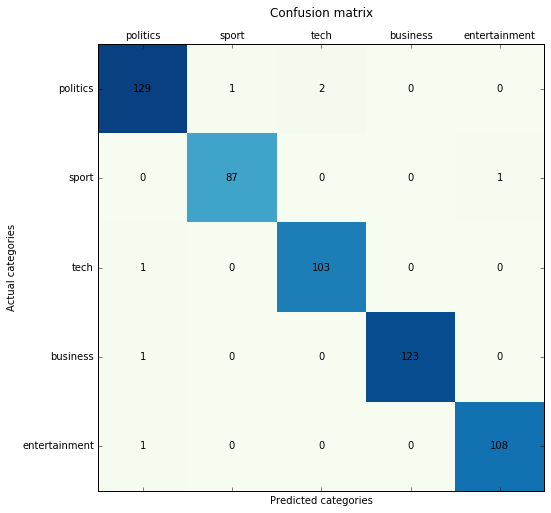

In [24]:
svc_d2v_Y_pred = svc_d2v_best.predict(d2v_X_test)

# Compute precision, recall and F1 scores with micro and macro averaging
svc_d2v_precision_micro = precision_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='micro')
svc_d2v_precision_macro = precision_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='macro')
svc_d2v_recall_micro = recall_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='micro')
svc_d2v_recall_macro = recall_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='macro')
svc_d2v_f1_micro = f1_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='micro')
svc_d2v_f1_macro = f1_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='macro')

precisions_micro.append(svc_d2v_precision_micro)
precisions_macro.append(svc_d2v_precision_macro)
recalls_micro.append(svc_d2v_recall_micro)
recalls_macro.append(svc_d2v_recall_macro)
f1s_micro.append(svc_d2v_f1_micro)
f1s_macro.append(svc_d2v_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (svc_d2v_precision_micro, svc_d2v_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (svc_d2v_recall_micro, svc_d2v_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (svc_d2v_f1_micro, svc_d2v_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(d2v_Y_test, svc_d2v_Y_pred)

### Multi-layer Perceptron (Keras-based) approach

In [15]:
# Create MLP
def build_mlp(hidden_layer_1_size=32, hidden_layer_2_size=16, dropout_1_2=0.1):
    mlp_model = Sequential()

    mlp_model.add(Dense(hidden_layer_1_size, input_dim=doc2vec_vector_size, activation='tanh'))
    
    if dropout_1_2 > 0.0:
        mlp_model.add(Dropout(dropout_1_2))
    
    if hidden_layer_2_size > 0:
        mlp_model.add(Dense(hidden_layer_2_size, activation='tanh'))
        
    mlp_model.add(Dense(len(bbc_news_categories.keys()), activation='softmax'))

    mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return mlp_model

In [47]:
# Convert classes to categories (0, 1, 2, 3, 4)
bbc_news_Y_n = map(lambda x: x - 1, bbc_news_Y)

# Split the whole corpus in train and test sets
scaler = StandardScaler()
mlp_X_train, mlp_X_test, mlp_Y_train, mlp_Y_test = train_test_split(scaler.fit_transform(bbc_news_vectors), 
                                                                    array(bbc_news_Y_n).astype(floatx()), test_size=0.25)

# Create scaler and Keras-Scikit-Learn classifier
mlp_classifier = KerasClassifier(build_mlp, verbose=0, hidden_layer_1_size=32, hidden_layer_2_size=16, dropout_1_2=0.1)

# Grid search parameters
mlp_param_grid = [
    { 
        'verbose': [ 0 ],
        'batch_size': [ 8, 16, 32 ],
        'nb_epoch': [ 10, 20, 30, 50 ],
        'hidden_layer_1_size': [ 64, 32, 16 ],
        'hidden_layer_2_size': [ 32, 16, 8, 0 ],
        'dropout_1_2': [ 0.0, 0.1, 0.25 ]        
    }
]

# Perform grid search
mlp_gs = GridSearchCV(estimator=mlp_classifier, param_grid=mlp_param_grid, scoring='accuracy', cv=25, n_jobs=1)
mlp_gs.fit(array(mlp_X_train).astype(floatx()), mlp_Y_train)

# Create an instance of the best estimator
mlp_best = mlp_gs.best_estimator_
mlp_best.fit(array(mlp_X_train).astype(floatx()), mlp_Y_train)

print('Best model: %s' % str(mlp_gs.best_params_))
print('Best score: %f' % mlp_gs.best_score_)
print('Best test accuracy: %f' % mlp_best.score(array(mlp_X_test).astype(floatx()), mlp_Y_test))

Best model: {'dropout_1_2': 0.0, 'nb_epoch': 30, 'batch_size': 8, 'hidden_layer_2_size': 16, 'hidden_layer_1_size': 32, 'verbose': 0}
Best score: 0.968825
Best test accuracy: 0.956912


### Model evaluation

Precision score: 0.985637 (micro) / 0.984715 (macro)
Recall score: 0.985637 (micro) / 0.986193 (macro)
F1 score: 0.985637 (micro) / 0.985397 (macro)


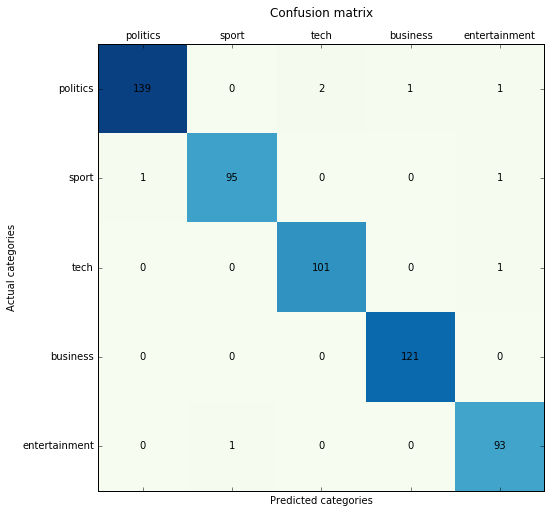

In [48]:
mlp_Y_pred = mlp_best.predict(array(mpl_X_test).astype(floatx()))

# Compute precision, recall and F1 scores with micro and macro averaging
mlp_precision_micro = precision_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='micro')
mlp_precision_macro = precision_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='macro')
mlp_recall_micro = recall_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='micro')
mlp_recall_macro = recall_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='macro')
mlp_f1_micro = f1_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='micro')
mlp_f1_macro = f1_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='macro')

precisions_micro.append(mlp_precision_micro)
precisions_macro.append(mlp_precision_macro)
recalls_micro.append(mlp_recall_micro)
recalls_macro.append(mlp_recall_macro)
f1s_micro.append(mlp_f1_micro)
f1s_macro.append(mlp_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (mlp_precision_micro, mlp_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (mlp_recall_micro, mlp_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (mlp_f1_micro, mlp_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(map(lambda x: x + 1, mpl_Y_test), map(lambda x: x + 1, mlp_Y_pred))

## Performance comparison

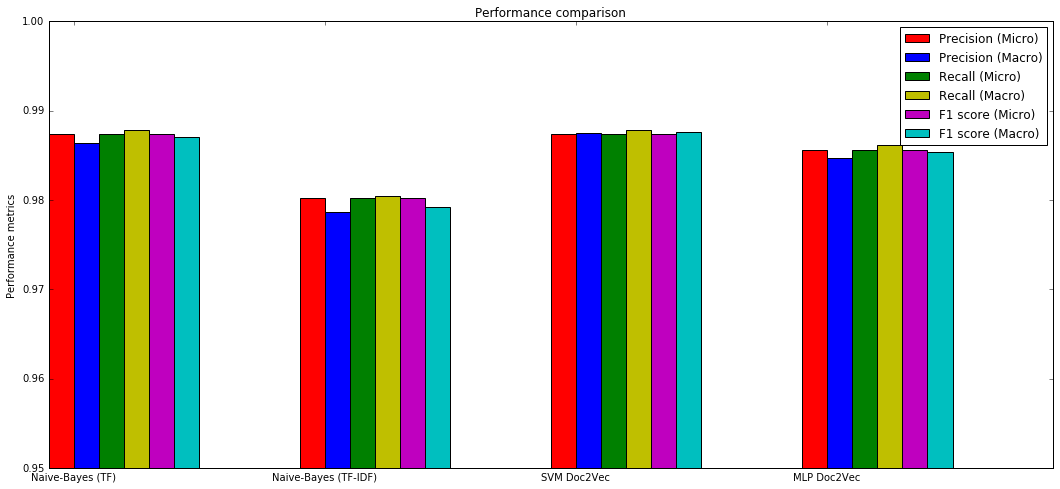

In [54]:
cmp_fig, cmp_ax = subplots(figsize=(18.0, 8.0))

pmicro = cmp_ax.bar(arange(4), precisions_micro, 0.1, color='r')
pmacro = cmp_ax.bar(arange(4) + 0.1, precisions_macro, 0.1, color='b')
rmicro = cmp_ax.bar(arange(4) + (2 * 0.1), recalls_micro, 0.1, color='g')
rmacro = cmp_ax.bar(arange(4) + (3 * 0.1), recalls_macro, 0.1, color='y')
f1micro = cmp_ax.bar(arange(4) + (4 * 0.1), f1s_micro, 0.1, color='m')
f1macro = cmp_ax.bar(arange(4) + (5 * 0.1), f1s_macro, 0.1, color='c')

cmp_ax.set_ylabel('Performance metrics')
cmp_ax.set_title('Performance comparison')

cmp_ax.set_xticks(arange(4) + 0.1)
cmp_ax.set_ylim([0.95, 1.0])

cmp_ax.set_xticklabels(('Naive-Bayes (TF)', 'Naive-Bayes (TF-IDF)', 'SVM Doc2Vec', 'MLP Doc2Vec'))

cmp_ax.legend((pmicro[0], pmacro[0], rmicro[0], rmacro[0], f1micro[0], f1macro[0]), 
              ('Precision (Micro)', 'Precision (Macro)',
               'Recall (Micro)', 'Recall (Macro)',
               'F1 score (Micro)', 'F1 score (Macro)'))

#### As per overall analysis finally we can easily get the idea that which model should be perfect for the given data.

#### So Doc2Vec model is best and most populer model 